# Market Making with Alpha Signals

## H


### Parameters

In [2]:
from parameters import base_p


p = base_p
p.dalpha = 5

### Definitions

In [4]:
import numpy as np

# class H(SimpleNamespace): TODO: Transform H into a class that will generate H
#     def __init__(self, p)
q_max, T, A, dalpha, Delta, epsilon, psi, phi_, eta, sigma, k, xi, lambda_plus, lambda_minus = p.q_max, p.T, p.A, p.dalpha, p.Delta, p.epsilon, p.psi, p.phi_, p.eta, p.sigma, p.k, p.xi, p.lambda_plus, p.lambda_minus

Upsilon = Delta + epsilon

dt = p.dt

q_a = np.arange(-q_max, q_max + 1, 1)
alpha = np.arange(-A, A + 1, dalpha)

alpha_smaller_0 = np.where(alpha < 0)[0]
alpha_greater_0 = np.where(alpha > 0)[0]
alpha_0 = np.where(alpha == 0)[0]   

n_q = len(q_a)
n_alpha = len(alpha)
n_t = int(T / dt)

h = np.full((n_t, n_alpha, n_q), np.nan)
d_alpha_h = np.zeros(n_alpha)
dd_alpha_h = np.zeros(n_alpha)

l_plus = np.zeros((n_t, n_alpha, n_q))
l_minus = np.zeros((n_t, n_alpha, n_q))

h_eta_up = np.full((n_t, n_alpha, n_q), np.nan)
h_eta_down = np.full((n_t, n_alpha, n_q), np.nan)


def T_dt_dalpha(h, t_i, q_i, d_alpha_h, dd_alpha_h):
    h_t_1_q = h[t_i + 1, :, q_i]
    q_ = q_a[q_i]

    l_plus_term = get_l_plus_term(t_i, q_i, h_t_1_q)

    l_minus_term = get_l_minus_term(t_i, q_i, h_t_1_q)

    h_t_q = h_t_1_q + dt * (
        alpha * sigma * q_
        - k * alpha * d_alpha_h
        + ((xi**2) / 2) * dd_alpha_h
        - phi_ * q_**2
        + l_plus_term
        + l_minus_term
    )

    # impose second derivative vanishes along maximum and minimum values of alpha grid
    h_t_q[0] = 2 * h_t_q[1] - h_t_q[2]
    h_t_q[-1] = 2 * h_t_q[-2] - h_t_q[-3]
    return h_t_q


def get_l_minus_term(t_i, q_i, h_t_1_q):
    if q_a[q_i] < q_max:
        l_minus_term = lambda_minus * np.maximum(
            (Delta + h_eta_down[t_i + 1, :, q_i + 1] - h_t_1_q),
            (h_eta_down[t_i + 1, :, q_i] - h_t_1_q),
        )
    else:
        l_minus_term = h_eta_down[t_i + 1, :, q_i] - h_t_1_q
    return l_minus_term


def get_l_plus_term(t_i, q_i, h_t_1_q):
    if q_a[q_i] > -q_max:
        l_plus_term = lambda_plus * np.maximum(
            (Delta + h_eta_up[t_i + 1, :, q_i - 1] - h_t_1_q),
            (h_eta_up[t_i + 1, :, q_i] - h_t_1_q),
        )
    else:
        l_plus_term = h_eta_up[t_i + 1, :, q_i] - h_t_1_q
    return l_plus_term


def M_dt_dalpha(h, t_i, q_i):
    if q_a[q_i] < q_max and q_a[q_i] > -q_max:
        return np.maximum(
            (h[t_i + 1, :, q_i - 1] - Upsilon), (h[t_i + 1, :, q_i + 1] - Upsilon)
        )
    elif q_a[q_i] > -q_max:
        return h[t_i + 1, :, q_i - 1] - Upsilon
    elif q_a[q_i] < q_max:
        return h[t_i + 1, :, q_i + 1] - Upsilon
    else:
        raise ValueError(f"Imposible Case {q_a[q_i]}")


def S_dt_dalpha(h, t_i, q_i, d_alpha_h, dd_alpha_h):
    T_dt_dalpha_i = T_dt_dalpha(h, t_i, q_i, d_alpha_h, dd_alpha_h)
    M_dt_dalpha_i = M_dt_dalpha(h, t_i, q_i)
    return np.maximum(T_dt_dalpha_i, M_dt_dalpha_i)


def calculate_d_alpha_h(h_q_t):
    d_alpha_h[alpha_smaller_0] = (
        h_q_t[alpha_smaller_0 + 1] - h_q_t[alpha_smaller_0]
    ) / dalpha
    d_alpha_h[alpha_greater_0] = (
        h_q_t[alpha_greater_0] - h_q_t[alpha_greater_0 - 1]
    ) / dalpha
    d_alpha_h[alpha_0] = (
        (h_q_t[alpha_0 + 1] - h_q_t[alpha_0]) +
        (h_q_t[alpha_0] - h_q_t[alpha_0 - 1])
    ) / (2 * dalpha)
    return d_alpha_h


def calculate_dd_alpha_h(h_q_t):
    dd_alpha_h[1:-1] = (h_q_t[2:] - 2 * h_q_t[1:-1] - h_q_t[:-2]) / (dalpha**2)
    return dd_alpha_h


def extrapolate_up(phi, n, diff):
    delta_phi = phi[-1] - phi[-2]
    phi_extrapolated = (
        np.ones(n) * phi[-1] + diff * delta_phi + np.arange(0, n) * delta_phi
    )
    return phi_extrapolated


def interpolate(phi, up=True):
    eta_dalpha = eta / dalpha
    eta_dalpha_floor = np.floor(eta_dalpha)
    eta_dalpha_diff = eta_dalpha - eta_dalpha_floor
    eta_move = int(eta_dalpha_floor)

    phi_eta = phi if up else np.flip(phi)

    phi_eta = np.roll(phi_eta, -eta_move)
    phi_eta[-eta_move:] = np.nan

    phi_eta_1 = np.roll(phi_eta, -1)
    phi_eta_1[-1:] = np.nan

    phi_eta += (phi_eta_1 - phi_eta) * eta_dalpha_diff
    phi_eta[-eta_move - 1:] = extrapolate_up(
        phi if up else np.flip(phi), len(
            phi_eta[-eta_move - 1:]), eta_dalpha_diff
    )

    phi_eta = phi_eta if up else np.flip(phi_eta)

    return phi_eta


def find_optimal_postings(h, t_i, q_i):
    h_eta_up[t_i + 1, :, q_i] = interpolate(h[t_i + 1, :, q_i])
    if q_a[q_i] > -q_max:
        h_eta_up[t_i + 1, :, q_i - 1] = interpolate(h[t_i + 1, :, q_i - 1])
        l_plus_i = np.where(
            Delta + h_eta_up[t_i + 1, :, q_i -
                             1] > h_eta_up[t_i + 1, :, q_i], 1, 0
        )
    else:
        l_plus_i = np.zeros(n_alpha)

    h_eta_down[t_i + 1, :, q_i] = interpolate(h[t_i + 1, :, q_i], up=False)
    if q_a[q_i] < q_max:
        h_eta_down[t_i + 1, :, q_i +
                   1] = interpolate(h[t_i + 1, :, q_i + 1], up=False)
        l_minus_i = np.where(
            Delta + h_eta_down[t_i + 1, :, q_i +
                               1] > h_eta_down[t_i + 1, :, q_i], 1, 0
        )
    else:
        l_minus_i = np.zeros(n_alpha)
    return l_plus_i, l_minus_i


### Calculate H (takes long)

In [5]:
import time
# Terminal and boundary conditions
h[-1, :, :] = (
    np.ones((1, n_alpha)) *
    np.array([(q_a * (-np.sign(q_a) * Upsilon - psi * q_a))]).T
).T

time_2 = time.time()
for t_i in range(n_t - 2, -1, -1):
    time_1 = time.time()
    print(f"{n_t-t_i}/{n_t} - {(n_t-t_i)/n_t} - {t_i * (time_1 - time_2)/3600} h                          ", end='\r')
    time_2 = time.time()
    for q_i in range(n_q):
        h_q_t_1 = h[t_i + 1, :, q_i]
        d_alpha_h = calculate_d_alpha_h(h_q_t_1)
        dd_alpha_h = calculate_dd_alpha_h(h_q_t_1)
        l_plus[t_i + 1, :, q_i], l_minus[t_i + 1, :, q_i] = find_optimal_postings(
            h, t_i, q_i
        )
        h[t_i, :, q_i] = S_dt_dalpha(h, t_i, q_i, d_alpha_h, dd_alpha_h)

In [6]:
p.dalpha


5

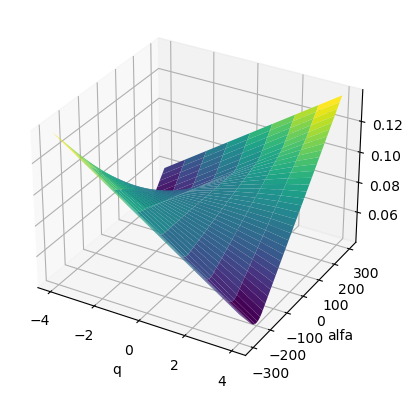

In [20]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

q_a = np.arange(-p.q_max, p.q_max + 1, 1)
alpha = np.arange(-p.A, p.A + 1, p.dalpha)

x, y = np.meshgrid(q_a, alpha)

fig = plt.figure()
axes = fig.add_subplot(projection = '3d')
axes.set_xlabel('q')
axes.set_ylabel('alfa')
axes.plot_surface(x, y, h[00,:,:], cmap='viridis')


plt.show()

# plt.savefig(f"../Propuesta/figuras/h_final_{p.phi_}_.png", dpi=150)

In [8]:
np.save(f"h_{p.phi_}_{p.dalpha}.npy",h)
np.save(f"q_{p.phi_}_{p.dalpha}.npy",q_a)
np.save(f"alpha_{p.phi_}_{p.dalpha}.npy", alpha)
np.save(f"l_plus_{p.phi_}_{p.dalpha}.npy", l_plus)
np.save(f"l_minus_{p.phi_}_{p.dalpha}.npy", l_minus)

### Obtain optimal MO postings (takes long)

In [11]:
import numpy as np
h = np.load(f"h_{p.phi_}_{p.dalpha}.npy")
q_a = np.load(f"q_{p.phi_}_{p.dalpha}.npy")
alpha = np.load(f"alpha_{p.phi_}_{p.dalpha}.npy")
l_plus = np.load(f"l_plus_{p.phi_}_{p.dalpha}.npy")
l_minus = np.load(f"l_minus_{p.phi_}_{p.dalpha}.npy")

In [21]:
def find_optimal_MO(h, t_i, q_i):
    # if q_a[q_i] <= q_max and q_a[q_i] >= -q_max:
    #     postings = np.where(M_dt_dalpha(h, t_i, q_i) > h[t_i, :, q_i], 1, 0)
    # else:
    #     postings = np.zeros(n_alpha)
    
    # if q_a[q_i] > 0:
    #     mo_minus_i = postings
    #     mo_plus_i = np.zeros(n_alpha)
    # elif q_a[q_i] < 0:
    #     mo_minus_i = np.zeros(n_alpha)
    #     mo_plus_i = postings
    # else:
    #     mo_minus_i = np.zeros(n_alpha)
    #     mo_plus_i = np.zeros(n_alpha)

    if q_a[q_i] > -(q_max - 1):
        # h_eta_down_q_m_1 = interpolate(h[t_i + 1, :, q_i - 1], up=False)
        # mo_minus_i = np.where(- Upsilon + h_eta_down_q_m_1 > h[t_i + 1, :, q_i], 1, 0)
        mo_minus_i = np.where((h[t_i + 1, :, q_i - 1] - Upsilon) > h[t_i + 1, :, q_i], 1, 0)
    else:
        mo_minus_i = np.zeros(n_alpha)

    if q_a[q_i] < (q_max - 1):
        # h_eta_up_q_p_1 = interpolate(h[t_i + 1, :, q_i + 1])
        # mo_plus_i = np.where(- Upsilon + h_eta_up_q_p_1 > h[t_i + 1, :, q_i], 1, 0)
        mo_plus_i = np.where((h[t_i + 1, :, q_i + 1] - Upsilon) > h[t_i + 1, :, q_i],1,0)
    else:
        mo_plus_i = np.zeros(n_alpha)


    return mo_plus_i, mo_minus_i

In [22]:
mo_plus = np.zeros((n_t, n_alpha, n_q))
mo_minus = np.zeros((n_t, n_alpha, n_q))

for t_i in range(n_t - 2, -1, -1):
    for q_i in range(n_q):
        mo_plus[t_i + 1, :, q_i], mo_minus[t_i + 1, :, q_i] = find_optimal_MO(
            h, t_i, q_i
        )

In [23]:
np.save(f"mo_plus_{p.phi_}_{p.dalpha}.npy", mo_plus)
np.save(f"mo_minus_{p.phi_}_{p.dalpha}.npy", mo_minus)


## Pure Jump Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In this case the poisson arrivals are created by simulating the entire T time and ordering those uniformly. This simulation is interpreting the Poisson process as a distribution of point counts. In this way time between arrivals have an exponential probability distribution.

117
[0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1
 0 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1
 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1
 0 1 1 0 0 1]
[-1 -1 -1 -1 -1  1  1  1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1  1  1 -1 -1
 -1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1  1  1 -1 -1  1  1 -1 -1 -1
 -1  1  1 -1  1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1  1  1  1 -1
 -1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1 -1  1 -1 -1 -1
  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]


(array([47., 28., 17.,  7.,  6.,  2.,  4.,  0.,  1.,  4.]),
 array([1.34368354e-03, 2.51790198e-01, 5.02236712e-01, 7.52683226e-01,
        1.00312974e+00, 1.25357625e+00, 1.50402277e+00, 1.75446928e+00,
        2.00491580e+00, 2.25536231e+00, 2.50580882e+00]),
 <BarContainer object of 10 artists>)

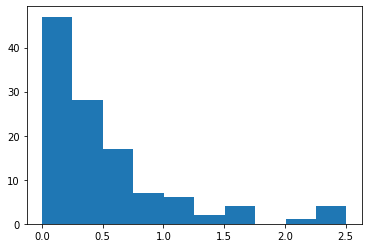

In [2]:
T=60
np.random.seed(1)
lambda_ = (1., 1.)
sigma = 1
number_of_market_orders=np.random.poisson(sum(lambda_) * T)
print(number_of_market_orders)
times = np.sort(np.random.uniform(size=number_of_market_orders)*T)
#print(times)
markers = np.random.binomial(n=1, p=lambda_[1] / sum(lambda_), size=number_of_market_orders)
jumps = np.where(markers == 0, -1, 1)
print(markers)
print(jumps)
s = sigma * np.cumsum(jumps)
plt.hist(np.diff(times))


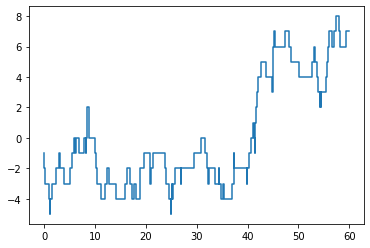

In [3]:
plt.step(times, s)

## Other way of simulating poisson arrivals

On the other hand, generating a random uniform variable for each dt will also generate a possion distribution if at each time we analyze the exponential probability distribution required. We are interpreting the poisson process as a counting process.

Thus, as for a Poisson process

$P(N_t - N_0 = n ) = \frac{(\lambda t)^n}{n!}e^{-\lambda t}$

Considering the probability of more than one arrival in dt negligible then

$P(N_t-N_{t-1}=n \neq 0)= \sum_{i=1}^{\infty} \frac{(\lambda dt)^i}{i!}e^{-\lambda dt}$

$P(N_t-N_{t-1}=n \neq 0)= 1-e^{-\lambda dt}$

which is the exponential distribution, as expected for the time of arrivales of a Poisson Process

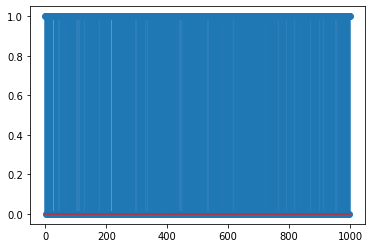

(array([381.,   0., 177.,   0.,  48.,   0.,  14.,   0.,   9.,   3.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

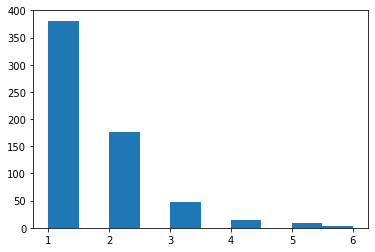

In [4]:
l = 1
n=1000
dt=1
arrivals = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (l))), decimals=4),1,0)
plt.stem(arrivals)
plt.show()

t=np.array(range(n))
arrival_times = arrivals*t
arrival_times = arrival_times[arrival_times != 0]
arrival_times
distribution = np.diff(arrival_times)
plt.hist(distribution)

## Simulation of paths
dAlpha and dS as of Market Making with Alpha Signals

### Experimenting

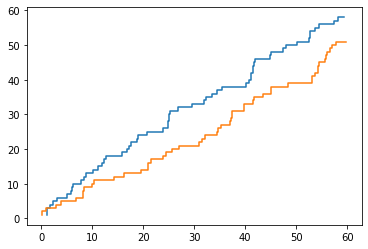

In [5]:
T=60
np.random.seed(1)
lambda_ = (1., 1.)
number_of_market_orders_buy=np.random.poisson(lambda_[0] * T)
number_of_market_orders_sell=np.random.poisson(lambda_[1] * T)
tau_plus = np.sort(np.random.uniform(size=number_of_market_orders_buy)*T)
tau_minus = np.sort(np.random.uniform(size=number_of_market_orders_sell)*T)
dMt_plus = np.ones(number_of_market_orders_buy)
dMt_minus = np.ones(number_of_market_orders_sell)
Mt_plus = dMt_plus.cumsum()
Mt_minus = dMt_minus.cumsum()
plt.step(tau_plus, Mt_plus)
plt.step(tau_minus, Mt_minus)


As in Jaimungal we can iterate in t but simulate across using an n size vector, generating n simulations at once.

Also since $d \alpha_t = -k \alpha_t dt$ then, $\alpha_t = c * e^{-k t}$

Alpha thus have a mean reverting component. 

I don't get why Jaimungal solves it using $\alpha_t = e^{-\zeta * dt} * \alpha_{t-1} $ since in the page 220 of AHFT solution is $\alpha_t = \alpha_0 e^{-k t}$

I guess since $\alpha_t = \alpha_0 e^{-k t}$, 

then

$\alpha_{t + dt} = \alpha_0 e^{-k (t+dt)}$

$\alpha_{t + dt} = \alpha_0 e^{-kt-k*dt}$

$\alpha_{t + dt} = \alpha_0 e^{-kt}e^{-k*dt}$

$\alpha_{t + dt} = \alpha_t e^{-k*dt}$

Condition as in paper:

$d\alpha_t=-k\alpha_t dt + \xi dW_t + \eta^+ (dM_t^{0+}+dM_t^+)-\eta^-(dMt_t^{0-}+dM_t^-), \alpha_0=0$


### Generate simulations

In [28]:
import numpy as np
h = np.load(f"h_{p.phi_}_{p.dalpha}.npy")
q_a = np.load(f"q_{p.phi_}_{p.dalpha}.npy")
alpha = np.load(f"alpha_{p.phi_}_{p.dalpha}.npy")
l_plus = np.load(f"l_plus_{p.phi_}_{p.dalpha}.npy")
l_minus = np.load(f"l_minus_{p.phi_}_{p.dalpha}.npy")
mo_plus = np.load(f"mo_plus_{p.phi_}_{p.dalpha}.npy")
mo_minus = np.load(f"mo_minus_{p.phi_}_{p.dalpha}.npy")

In [54]:
# TODO: Create class Simulator or similar
from matplotlib import pyplot as plt

np.random.seed(1)
dMt_minus = 0
dMt_plus = 0


def generate_simulations(p, h, l_p, l_m, mo_p, mo_m, plot=False, drift=True):
    n, k, eta_plus, eta_minus, lambda_plus, lambda_minus, T, xi, sigma, theta, s0, A, dalpha, q_max, Delta, epsilon = p.n, p.k, p.eta, p.eta, p.lambda_plus, p.lambda_minus, p.T, p.xi, p.sigma, p.theta, p.s0, p.A, p.dalpha, p.q_max, p.Delta, p.epsilon

    Upsilon = Delta + epsilon

    dt = (k * A / dalpha + lambda_plus + lambda_minus)**(-1)
    
    m = int(T/dt)
    
    # Alpha setup
    alpha = np.full((n, m), np.nan)
    alpha[:, 0] = 0
    alpha_range = np.arange(-A, A + 1, dalpha)

    tau_plus_amounts = np.random.poisson(lambda_plus*T, n)
    tau_minus_amounts = np.random.poisson(lambda_minus*T, n)
    tau_plus = [np.sort(np.random.rand(tau_i) * T) for tau_i in tau_plus_amounts]
    tau_minus = [np.sort(np.random.rand(tau_i) * T) for tau_i in tau_minus_amounts]

    dMt0_plus = np.array([np.histogram(tau_i,np.linspace(0,T,m+1))[0] for tau_i in tau_plus])
    dMt0_minus = np.array([np.histogram(tau_i,np.linspace(0,T,m+1))[0] for tau_i in tau_minus])

    # S setup
    s = np.full((n, m), np.nan)
    s[:, 0] = s0

    mu_plus = np.full((n, m), np.nan)
    mu_plus[:, 0] = theta
    mu_minus = np.full((n, m), np.nan)
    mu_minus[:, 0] = theta

    dJ_plus = np.full((n, m), np.nan)
    dJ_plus[:, 0] = 0

    dJ_minus = np.full((n, m), np.nan)
    dJ_minus[:, 0] = 0

    # Positions setup
    l_p_position = np.full((n, m), np.nan)
    l_m_position = np.full((n, m), np.nan)

    p_postings = np.full((n, m), np.nan)
    m_postings = np.full((n, m), np.nan)

    p_executions = np.full((n, m), np.nan)
    m_executions = np.full((n, m), np.nan)

    p_executions_count = np.full((n, m), np.nan)
    m_executions_count = np.full((n, m), np.nan)

    mo_p_executions = np.full((n, m), np.nan)
    mo_m_executions = np.full((n, m), np.nan)

    dMt_plus = np.full((n, m), np.nan) # np.zeros((n, m))
    dMt_minus = np.full((n, m), np.nan) # np.zeros((n, m))

    pnl = np.full((n, m), np.nan)
    pnl[:, 0] = 0

    X = np.full((n, m), np.nan)
    X[:, 0] = 0

    def get_closest_index(val):
        return int(np.round(min(max(-p.A,val),p.A) / p.dalpha, 0)) + int(p.A / p.dalpha)

    def get_l_p(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return l_p[t_i, alpha_i, q_i]
    get_l_p_v = np.vectorize(get_l_p)

    def get_l_m(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return l_m[t_i, alpha_i, q_i]
    get_l_m_v = np.vectorize(get_l_m)

    def get_MM_MO_p(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return mo_p[t_i, alpha_i, q_i]
    get_MM_MO_p_v = np.vectorize(get_MM_MO_p)
    
    def get_MM_MO_m(t_i, alpha_val, q):
        alpha_i = get_closest_index(alpha_val)
        q_i = int(q + q_max)
        return mo_m[t_i, alpha_i, q_i]
    get_MM_MO_m_v = np.vectorize(get_MM_MO_m)

    # Inventory setup
    q = np.full((n, m), np.nan)
    q[:, 0] = 0

    # Simulations
    print(f"Amount of simulations: {n}")
    for i in range(m-1):
        print(f"%{float(i)/float(m)*100.}", end="\r")
        # Set market order and limit order strategy
        # consider alpha for positining or not
        if drift:  
            alpha_i = alpha[:, i]
        else:
            alpha_i = np.zeros([1, len(alpha[:, i])])
        # dMt_minus and dMt_plus depend on the MM
        dMt_plus[:, i] = get_MM_MO_p_v(i, alpha_i, q[:, i])
        dMt_minus[:, i] = get_MM_MO_m_v(i, alpha_i, q[:, i])
        # limit order positions 
        l_p_position[:, i] = get_l_p_v(i, alpha_i, q[:, i])
        l_m_position[:, i] = get_l_m_v(i, alpha_i, q[:, i])

        alpha[:, i+1] = alpha[:,i] * np.exp(-k * dt) + xi * np.sqrt(dt) * (np.random.randn(n)) + eta_plus *(dMt0_plus[:,i] + dMt_plus[:, i]) - eta_minus * (dMt0_minus[:,i] + dMt_minus[:, i])

        mu_plus[:, i+1] = np.where(alpha[:, i+1]>0, alpha[:, i+1],0) + theta
        mu_minus[:, i+1] = np.where(alpha[:, i+1]<0, -alpha[:, i+1],0) + theta

        dJ_plus[:, i+1] = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (mu_plus[:,i+1]))), decimals=4),1,0)
        dJ_minus[:, i+1] = np.where(np.random.rand(n) < np.around((1 - np.exp(-dt * (mu_minus[:,i+1]))), decimals=4),1,0)
        
        s[:,i+1] = s[:,i] + sigma * (dJ_plus[:, i+1] - dJ_minus[:, i+1])

        q[:, i+1] = q[:, i] - np.where(l_p_position[:, i] * dMt0_plus[:, i] > 0,1,0) + np.where((l_m_position[:, i] * dMt0_minus[:, i]) > 0,1,0) - np.where(dMt_minus[:, i] > 0,1,0) + np.where(dMt_plus[:,i] > 0,1,0)

        p_postings[:, i] = np.where(l_p_position[:,i]==0, np.nan, (s[:,i]+Delta)*l_p_position[:,i])
        p_executions_count[:,i] = np.where(l_p_position[:,i]*dMt0_plus[:,i]==0, 0, 1)
        p_executions[:, i] = np.where(l_p_position[:,i]*dMt0_plus[:,i]==0, np.nan, (s[:,i]+Delta)*l_p_position[:,i]*np.where(dMt0_plus[:,i]>0,1,0))
        
        m_postings[:,i] = np.where(l_m_position[:,i]==0, np.nan, (s[:,i]-Delta)*l_m_position[:,i])
        m_executions_count[:,i] = np.where(l_m_position[:,i]*dMt0_minus[:,i]==0, 0, 1)
        m_executions[:,i] = np.where(l_m_position[:,i]*dMt0_minus[:,i]==0, np.nan, (s[:,i]-Delta)*l_m_position[:,i]*np.where(dMt0_minus[:,i]>0,1,0))

        mo_p_executions[:,i] = np.where(dMt_plus[:, i]==0, np.nan, (s[:,i]+Upsilon)*dMt_plus[:, i])
        mo_m_executions[:,i] = np.where(dMt_minus[:, i]==0, np.nan, (s[:,i]-Upsilon)*dMt_minus[:, i])

        X[:,i+1] = X[:,i] + np.where(p_executions[:,i+1] > 0, s[:, i+1] + Delta, 0) - np.where(m_executions[:,i+1] > 0, s[:, i+1]-Delta, 0)\
            - np.where(mo_p_executions[:,i+1] > 0, s[:, i+1] + Upsilon, 0) \
            + np.where(mo_m_executions[:,i+1] > 0, s[:, i+1] - Upsilon, 0)

        pnl[:,i+1] = pnl[:,i] + np.where(p_executions[:,i] > 0, Delta, 0) + np.where(m_executions[:,i] > 0, Delta, 0)\
            + q[:, i] * (s[:, i+1] - s[:, i]) \
            - np.where(mo_p_executions[:,i+1] > 0, Upsilon, 0) \
            - np.where(mo_m_executions[:,i+1] > 0, Upsilon, 0)
        
    X[:,-1] = X[:,-1] - q[:, -1] * (s[:, -1]) - np.abs(q[:,-1])*Upsilon
    # pnl[:,-1] = pnl[:,-1] - Upsilon * np.abs(q[:,-1])

    print(f"Mean of PNL:{np.average(pnl[:,-1])}")
    print(f"Stde of PNL:{np.std(pnl[:,-1])}")
    print(f"Mean of X:{np.average(X[:,-1])}")
    print(f"Stde of X:{np.std(X[:,-1])}")

    if plot:
        plt_i = 1
        plt.figure(figsize=(25/2,7/2))
        # plt.title('Alpha')
        plt.xlabel('t')
        plt.ylabel('alfa')
        plt.step(np.linspace(0,T,m),alpha[plt_i])
        plt.savefig("../Propuesta/figuras/alpha_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        plt.figure(figsize=(25/2,7/2))

        # plt.title('S')
        plt.xlabel('t')
        plt.ylabel('S')
        plt.step(np.linspace(0,T,m), s[plt_i], c='black')
        
        plt.step(np.linspace(0,T,m), p_postings[plt_i], c='b')
        plt.scatter(np.linspace(0,T,m), p_executions[plt_i], marker='x', c='b')

        plt.step(np.linspace(0,T,m), m_postings[plt_i], c='r')
        plt.scatter(np.linspace(0,T,m), m_executions[plt_i], marker='x', c='r')

        plt.scatter(np.linspace(0,T,m), mo_m_executions[plt_i], marker='s', c='b')
        plt.scatter(np.linspace(0,T,m), mo_p_executions[plt_i], marker='s', c='r')
        
        plt.savefig("../Propuesta/figuras/orders_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        print(f"MO_p: {np.nansum(dMt_plus[plt_i])}")
        print(f"MO_m: {np.nansum(dMt_minus[plt_i])}")
        print(f"LO_p: {np.nansum(m_executions_count[plt_i])}")
        print(f"LO_m: {np.nansum(p_executions_count[plt_i])}")

        plt.figure(figsize=(5,5))
        # plt.title('Limit Orders Minus Executions')
        plt.xlabel('Ordenes ejecutadas')
        plt.ylabel('Conteo')
        plt.hist(m_executions_count[:,:-1].sum(axis=1))
        plt.savefig("../Propuesta/figuras/limit_orders_minus_executions_final",dpi=150,bbox_inches="tight",pad_inches=0.1)
        
        plt.figure(figsize=(5,5))
        # plt.title('Limit Orders Plus Executions')
        plt.xlabel('Ordenes ejecutadas')
        plt.ylabel('Conteo')
        plt.hist(p_executions_count[:,:-1].sum(axis=1))
        plt.savefig("../Propuesta/figuras/limit_orders_plus_executions_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        plt.figure(figsize=(5,5))
        # plt.title('Market Orders Minus Executions')
        plt.xlabel('Ordenes ejecutadas')
        plt.ylabel('Conteo')
        plt.hist(dMt_minus[:, :-1].sum(axis=1))
        plt.savefig("../Propuesta/figuras/market_orders_minus_executions_final",dpi=150,bbox_inches="tight",pad_inches=0.1)
        
        plt.figure(figsize=(5,5))
        # plt.title('Market Orders Plus Executions')
        plt.xlabel('Ordenes ejecutadas')
        plt.ylabel('Conteo')
        plt.hist(dMt_plus[:, :-1].sum(axis=1))
        plt.savefig("../Propuesta/figuras/market_orders_plus_executions_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        if False:
            plt.figure()
            plt.title('$\mu_+$')
            plt.step(np.linspace(0,T,m),mu_plus[plt_i])

            plt.figure()
            plt.title('$\mu_-$')
            plt.step(np.linspace(0,T,m),mu_minus[plt_i])
        
        plt.figure(figsize=(25/2,7/2))
        # plt.title('$q$')
        plt.xlabel('t')
        plt.ylabel('q')
        plt.step(np.linspace(0,T,m),q[plt_i])
        plt.savefig("../Propuesta/figuras/q_final",dpi=150,bbox_inches="tight",pad_inches=0.1)

        plt.figure(figsize=(25/2,7/2))
        # plt.title('$pnl$')
        plt.xlabel('t')
        plt.ylabel('PnL')
        plt.step(np.linspace(0,T,m),pnl[plt_i])
        plt.savefig("../Propuesta/figuras/pnl_final",dpi=150,bbox_inches="tight",pad_inches=0.1)
        
        
    return alpha, mu_plus, mu_minus, dJ_plus, dJ_minus, s, l_p_position, l_m_position, q, dMt0_plus, dMt0_minus, pnl, dMt_plus, dMt_minus,p_executions_count, m_executions_count, pnl, X
# _ = generate_simulations(n, k, eta_plus, eta_minus, lambda_plus, lambda_minus, T, dt, xi, sigma, theta, s0, plot=True)
np.random.seed(2)
# example_params = SimpleNamespace(n=1, k=1, eta_plus=1, eta_minus=1, lambda_plus=1, lambda_minus=1, T=50, dt=0.01, xi=1, sigma=0.1, theta=1, s0=10)
alpha, mu_plus, mu_minus, dJ_plus, dJ_minus, s, l_p_position, l_m_position, q, dMt0_plus, dMt0_minus, pnl, dMt_plus, dMt_minus, p_executions_count, m_executions_count, pnl, X = generate_simulations(p, h, l_plus, l_minus, mo_plus, mo_minus, plot=False, drift=False)

Amount of simulations: 200
Mean of PNL:0.23407499999985593
Stde of PNL:0.1877931558258563
Mean of X:0.0
Stde of X:0.0


## alpha 200
Amount of simulations: 200

Mean of PNL:0.23497499999985672

Stde of PNL:0.18579928518439884

Mean of X:0.0

Stde of X:0.0

## non alpha 200
Amount of simulations: 200

Mean of PNL:0.23407499999985593

Stde of PNL:0.1877931558258563

Mean of X:0.0

Stde of X:0.0

In [18]:
print(np.average(non_alpha_pnl[:,-1]))
print(np.average(alpha_pnl[:,-1]))
print(np.std(non_alpha_pnl[:,-1]))
print(np.std(alpha_pnl[:,-1]))


0.20149999999984136
0.20204999999984197
0.1944884315326607
0.19415598754618493


In [55]:
alpha_non_pnl_200_6 = pnl

(array([ 2.,  5., 16., 24., 46., 46., 32., 20.,  7.,  2.]),
 array([-3.30000000e-01, -2.20000000e-01, -1.10000000e-01, -2.70672373e-13,
         1.10000000e-01,  2.20000000e-01,  3.30000000e-01,  4.40000000e-01,
         5.50000000e-01,  6.60000000e-01,  7.70000000e-01]),
 <BarContainer object of 10 artists>)

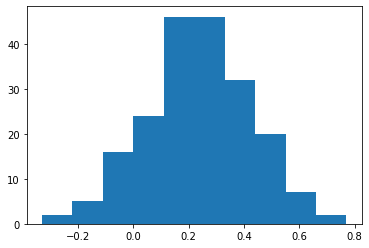

In [56]:
plt.hist(alpha_non_pnl_200_6[:,-1],)

In [11]:
alpha_pnl = pnl

(array([ 4.,  4.,  9., 19., 16., 20., 10.,  9.,  7.,  2.]),
 array([-0.25  , -0.1575, -0.065 ,  0.0275,  0.12  ,  0.2125,  0.305 ,
         0.3975,  0.49  ,  0.5825,  0.675 ]),
 <BarContainer object of 10 artists>)

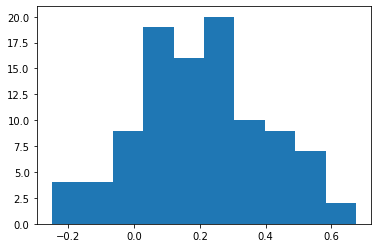

In [12]:
plt.hist(alpha_pnl[:,-1],)

In [57]:
import numpy as np
# np.save("alpha_pnl_200.npy", alpha_pnl_200)
np.save("alpha_non_pnl_200_6.npy", alpha_non_pnl_200_6)
# np.save("alpha_pnl.npy", alpha_pnl)
# np.save("non_alpha_pnl.npy", non_alpha_pnl)
# alpha_pnl = np.load("alpha_pnl.npy")
# non_alpha_pnl = np.load("non_alpha_pnl.npy")

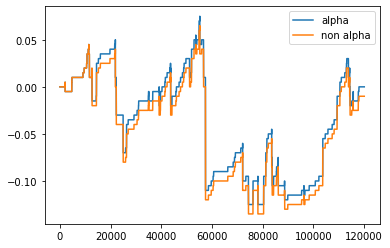

In [46]:
i=5
plt.plot(alpha_pnl[i,:], label='alpha')
plt.plot(non_alpha_pnl[i,:], label='non alpha')
plt.legend()

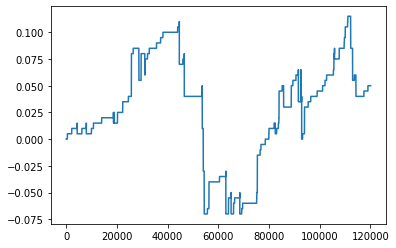

In [31]:
plt.plot(non_alpha_pnl[0,:])

In [22]:
pnls = np.array([alpha_pnl[:,-1], non_alpha_pnl[:,-1]]).transpose()
pnls.shape

(100, 2)

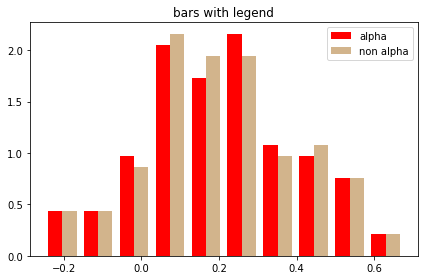

In [27]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 10
x = pnls

fig, ax = plt.subplots()

colors = ['red', 'tan']
labels = ['alpha', 'non alpha']
ax.hist(x, n_bins, density=True, histtype='bar', color=colors, label=labels)
ax.legend(prop={'size': 10})
ax.set_title('bars with legend')

fig.tight_layout()
plt.show()

(array([ 4.,  4.,  9., 19., 16., 20., 10.,  9.,  7.,  2.]),
 array([-0.25  , -0.1575, -0.065 ,  0.0275,  0.12  ,  0.2125,  0.305 ,
         0.3975,  0.49  ,  0.5825,  0.675 ]),
 <BarContainer object of 10 artists>)

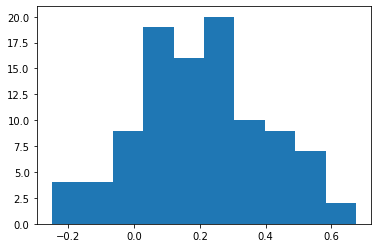

In [10]:
plt.hist(pnl[:,-1],)

In [1]:
np.std(pnl[:,-1])

NameError: name 'np' is not defined

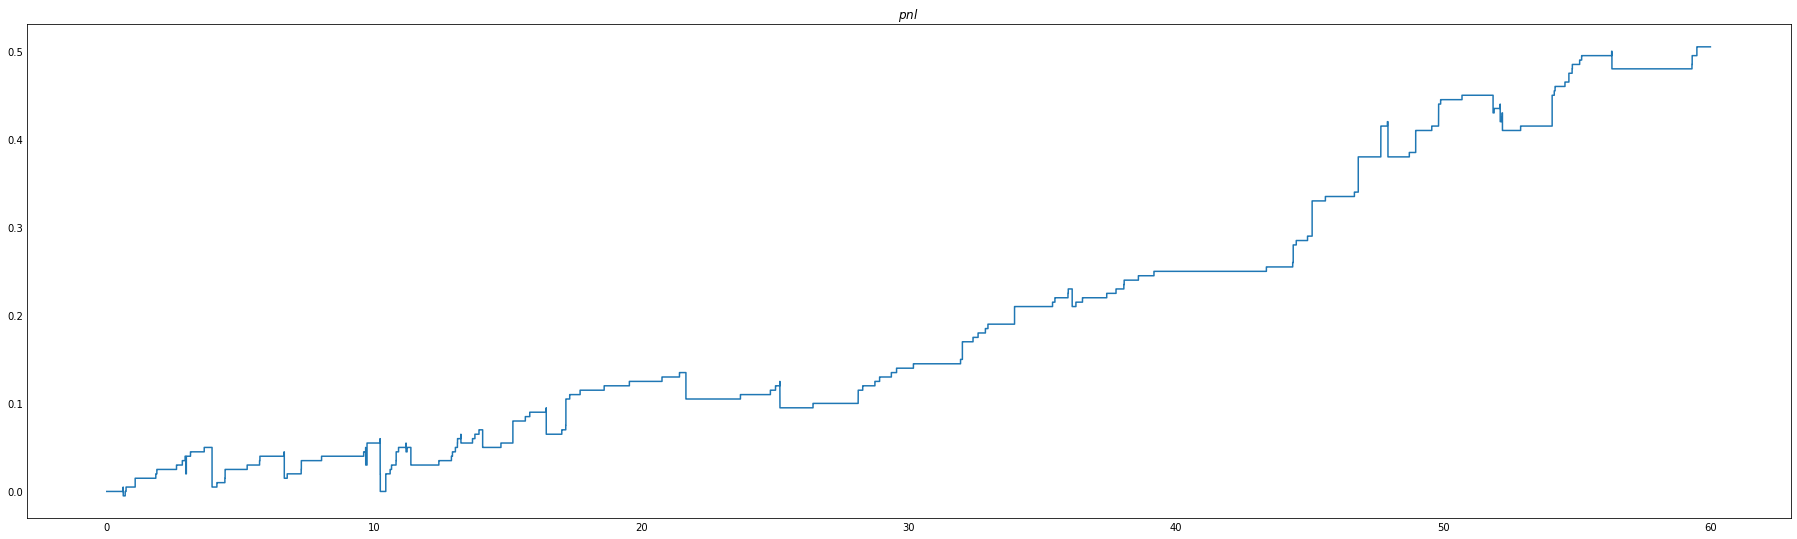

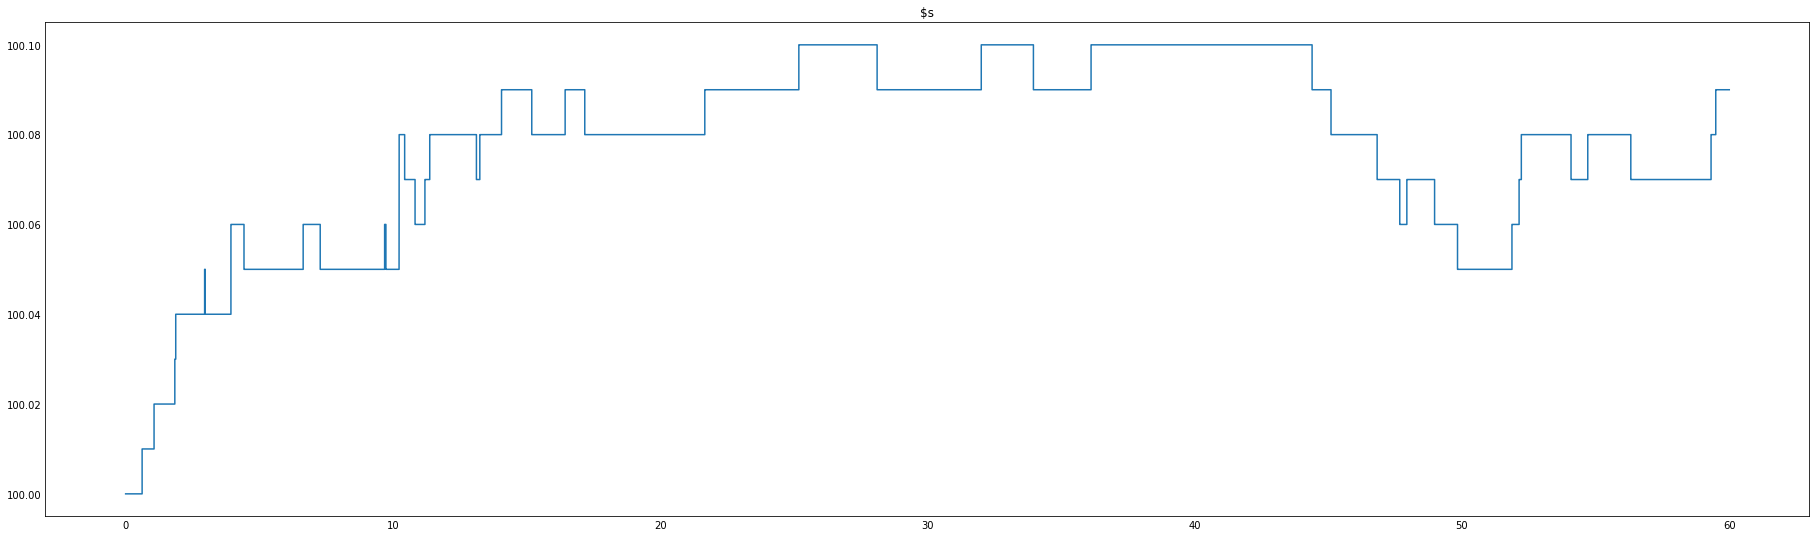

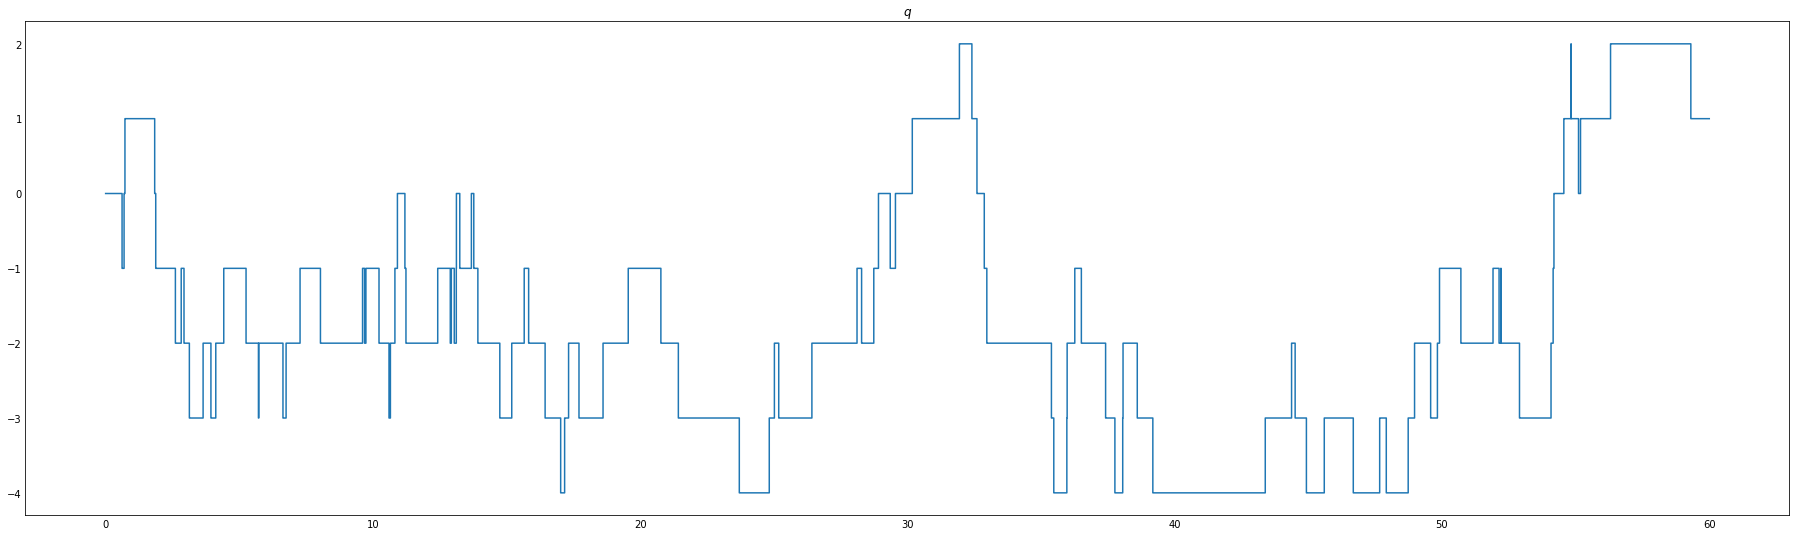

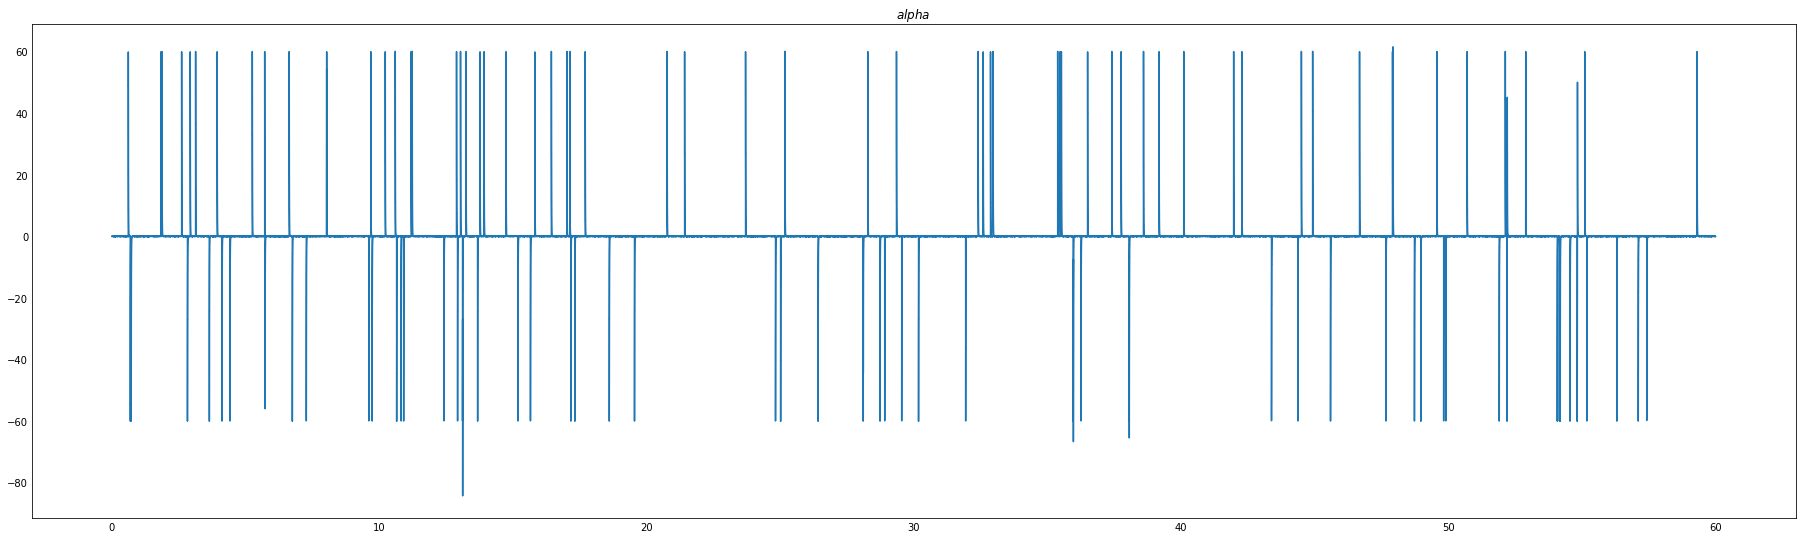

In [62]:
dt = (p.k * p.A / p.dalpha + p.lambda_plus + p.lambda_minus)**(-1)
m = int(p.T/dt)
plt_i = 1

plt.figure(figsize=(25,7))
plt.title('$pnl$')
plt.step(np.linspace(0,T,m),pnl[plt_i])

plt.figure(figsize=(25,7))
plt.title('$s')
plt.step(np.linspace(0,T,m),s[plt_i])

plt.figure(figsize=(25,7))
plt.title('$q$')
plt.step(np.linspace(0,T,m),q[plt_i])

plt.figure(figsize=(25,7))
plt.title('$alpha$')
plt.step(np.linspace(0,T,m),alpha[plt_i])


## Plots of positioning vs q

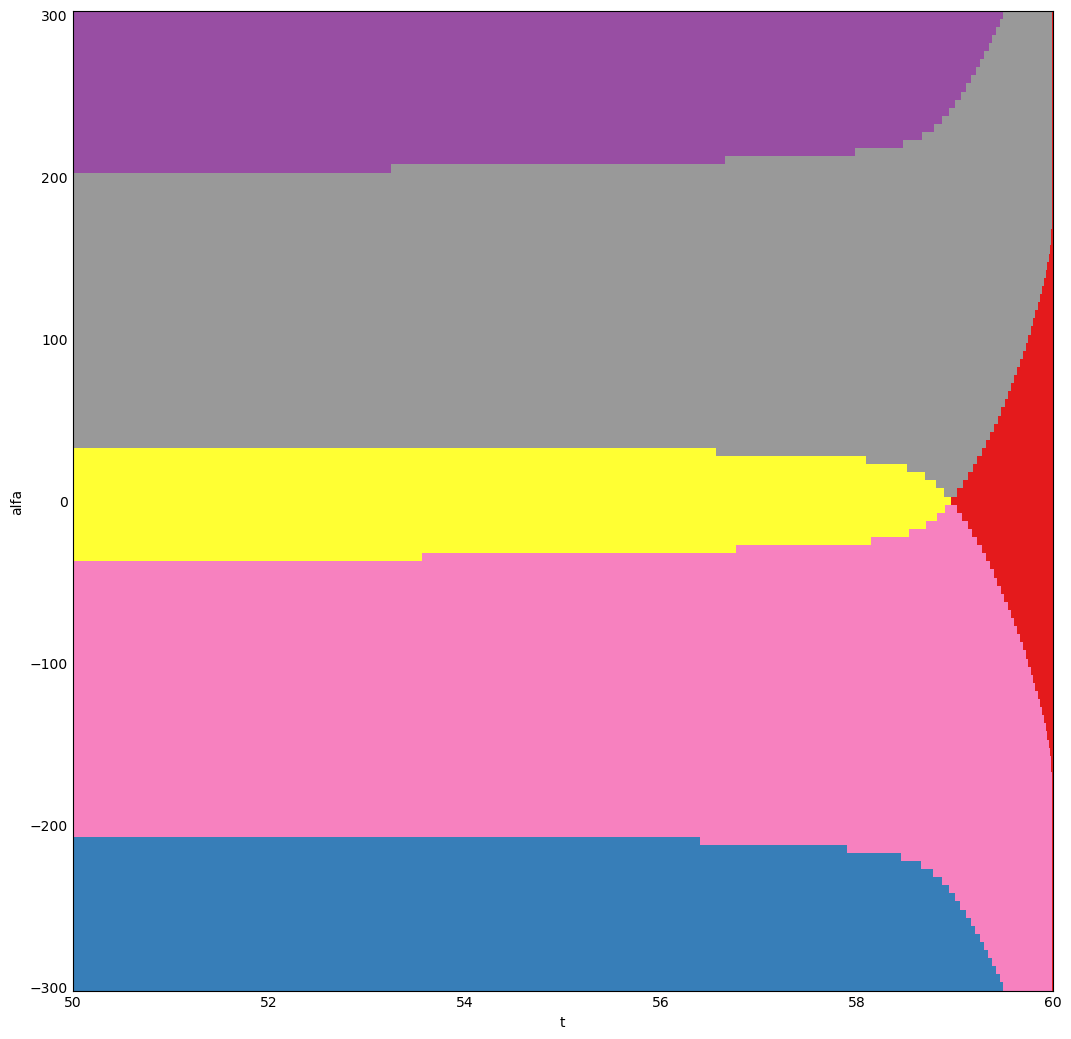

In [28]:
plt.style.use('_mpl-gallery-nogrid')

t_arange = np.arange(50,p.T,p.dt)
q_i = 4
# make data
X, Y = np.meshgrid(t_arange,np.arange(-p.A, p.A+1, p.dalpha))
Z_p = l_plus[-len(t_arange):,:,q_i].T
Z_m = l_minus[-len(t_arange):,:,q_i].T
Z_mo_p = mo_plus[-len(t_arange):,:,q_i].T
Z_mo_m = mo_minus[-len(t_arange):,:,q_i].T
# Z = - Z_mo_p - Z_m + Z_p + Z_mo_m
Z=np.select([Z_mo_m==1,Z_mo_p==1,Z_p*Z_m==1,Z_p==1,Z_m==1],[1,2,3,4,5])
levels = np.linspace(Z.min(), Z.max(), 10)

# plot
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel('t')
ax.set_ylabel('alfa')
# ax.contourf(X, Y, Z, levels=levels)
ax.pcolormesh(X, Y, Z, shading='nearest', vmin=Z.min(), vmax=Z.max(), cmap='Set1')

#plt.savefig("../Propuesta/figuras/positioning_vs_q_final",dpi=150, bbox_inches="tight",pad_inches=0.1)


In [63]:
Z

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]])

## Price Path Simulation with parameters as in MM with alpha signals paper (Figure 3 a, b)

### Notes on H
$\Upsilon = \Delta + \epsilon$ where $\Delta$ is the market spread and $\epsilon \gt 0$ represents the exchange fee.

Problem:

...

Development of solution:

Terminal condition:

$H(T,x,S,\alpha,q)=x+q(S-sign(q)\Upsilon-\psi q)$

Solution:



$H(t,x,S,\alpha,q)=x+qS+\hat{h}(t,\alpha, q)$

with terminal condition:

$\hat{h}(T,\alpha, q)=q(-sign(q)\Upsilon-\psi q)$

$\psi$ is a constant and $\psi Q_t$ represents the extra cost of walking the LOB at the end of the session.